In [10]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
import subprocess
from PIL import Image
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pprint import pprint
from tqdm import tqdm, tqdm_notebook

random.seed(165)

In [11]:
# DATA_PATH = "/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*"
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*" # <- needs to be normalized
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*" # <- needs to be normalized
DATA_PATH = "/home/satyarth934/data/nasa_impact/hurricanes/*/*"
MODEL_NAME = "baseAE_hurricane_try2"
BASE_DIR = "/home/satyarth934/code/FDL_2020/"
NORMALIZE = True
SAVE_FILES = True

OUTPUT_MODEL_PATH = BASE_DIR + "Models/" + MODEL_NAME
TENSORBOARD_LOG_DIR = BASE_DIR + "tb_logs/" + MODEL_NAME
ACTIVATION_IMG_PATH = BASE_DIR + "activation_viz/" + MODEL_NAME

FEATURES_PARENT_DIR = BASE_DIR + "Features/" + MODEL_NAME
PATH_LIST = FEATURES_PARENT_DIR + "/filenames.pkl"
FEATURES_OUTPUT = FEATURES_PARENT_DIR + "/features.pkl"

# NUM_EPOCHS = 200

# dust_labels = {0: "Dust", 1: "Hazy", 2: "No Dust"}

In [12]:
X_test_paths = pickle.load(file=open((PATH_LIST), 'rb'))
feature_list = pickle.load(file=open((FEATURES_OUTPUT), 'rb'))

In [13]:
num_images = len(X_test_paths)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  1069
Number of features per image =  3920


In [14]:
# Use scikit-learn to find Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=50,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

In [33]:
# wind_speed in knots
def getCategory(wind_speed):
    if wind_speed <= 33:
        return 'TD'
    elif 34 <= wind_speed <= 63:
        return 'TS'
    elif 64 <= wind_speed <= 82:
        return 'C1'
    elif 83 <= wind_speed <= 95:
        return 'C2'
    elif 96 <= wind_speed <= 112:
        return 'C3'
    elif 113 <= wind_speed <= 136:
        return 'C4'
    elif wind_speed >= 137:
        return 'C5'


def classname(str):    
    file_name = str.split("/")[-1]
    wind_speed = int(file_name.split(".")[0].split("_")[-1].strip("kts"))
    return getCategory(wind_speed)


# Helper function to get the classname and filename
def classname_filename(filepath):
    return str(classname(filepath)) + '/' + filepath.split('/')[-1].split("_")[-1]


# Normalize the image to plot
def normalize(mat):
    normalized = (mat - np.nanmin(mat)) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances, dims):
    images = []
    for filename in filenames:
        np_img = resize(plt.imread((filename))[:,:,:3], dims)
        if NORMALIZE:
            np_img = normalize(np_img)
        
        images.append(np_img)
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        if SAVE_FILES:
            file_parent = BASE_DIR + "Features/Images/" + MODEL_NAME
            subprocess.call("mkdir -p " + file_parent, shell=True)
            output_path = file_parent + "/similar_%s_%s.pdf" % (filenames[i].split('/')[-1].split(".")[1], classname(filenames[i]))
            plt.savefig(output_path, format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

306
[306 931 221 739 669 140 413  84 148 656 522 629  98 344 228]
[0.0, 0.73, 0.83, 0.83, 0.86, 0.93, 0.93, 0.93, 0.94, 0.95, 0.96, 0.96, 0.97, 0.97, 0.97]
['ep072019_advTime_20190802T060000_goesTime_20190802T062536_intensity_60kts.png',
 'ep072019_advTime_20190802T060000_goesTime_20190802T082536_intensity_60kts.png',
 'ep072019_advTime_20190802T060000_goesTime_20190802T092537_intensity_60kts.png',
 'cp012019_advTime_20191014T000000_goesTime_20191014T042517_intensity_30kts.png']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


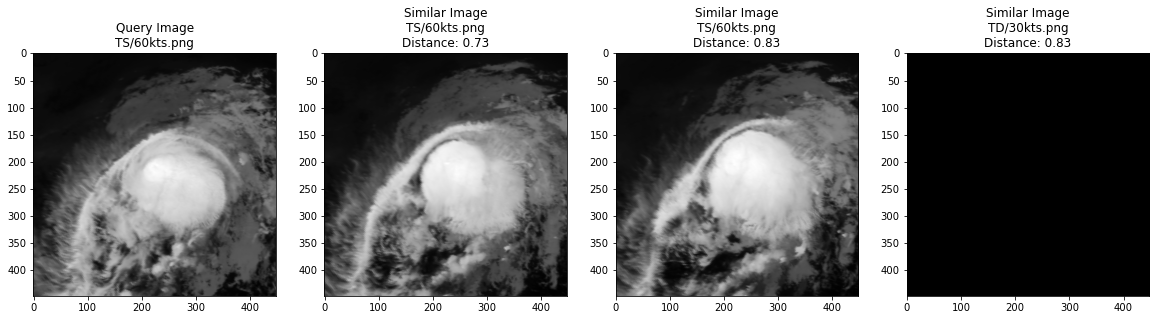

571
[ 571  698   59   49  507  261  316  814   97  134  759  714 1055  505
  245]
[0.0, 0.32, 0.45, 0.46, 0.47, 0.47, 0.48, 0.5, 0.53, 0.53, 0.54, 0.55, 0.57, 0.57, 0.58]
['al112019_advTime_20190917T180000_goesTime_20190917T202504_intensity_40kts.png',
 'al112019_advTime_20190917T150000_goesTime_20190917T172504_intensity_35kts.png',
 'al112019_advTime_20190918T120000_goesTime_20190918T172505_intensity_30kts.png',
 'al112019_advTime_20190918T120000_goesTime_20190918T152505_intensity_30kts.png']


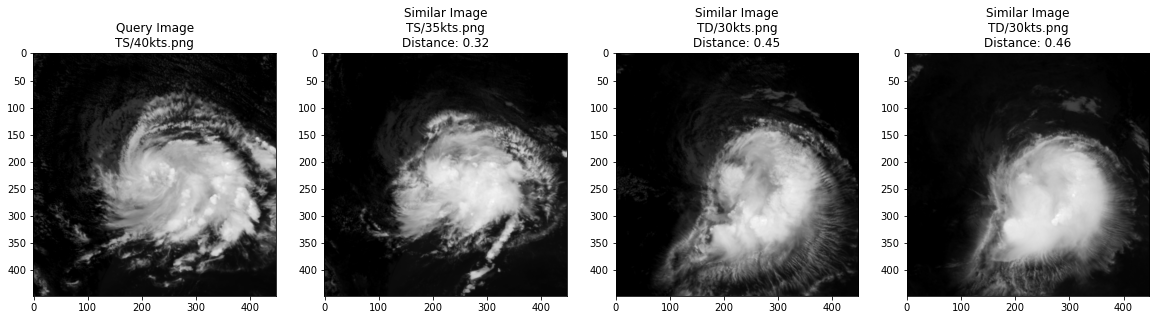

387
[ 387  443  435  878  970 1026  558  580  658  821  159  326  735  162
  830]
[0.0, 0.66, 0.68, 0.68, 0.68, 0.69, 0.69, 0.69, 0.69, 0.69, 0.7, 0.7, 0.7, 0.7, 0.71]
['ep182019_advTime_20191019T060000_goesTime_20191019T082520_intensity_30kts.png',
 'ep182019_advTime_20191019T120000_goesTime_20191019T142520_intensity_30kts.png',
 'ep182019_advTime_20191019T180000_goesTime_20191019T212520_intensity_30kts.png',
 'ep182019_advTime_20191019T180000_goesTime_20191019T222520_intensity_30kts.png']


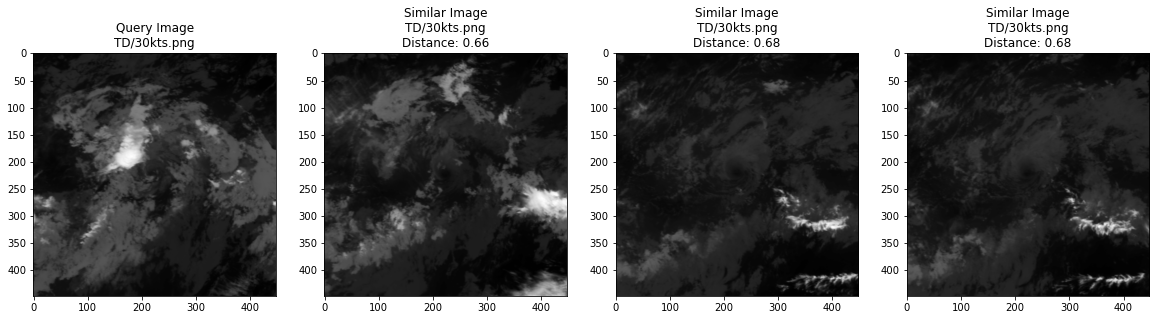

379
[ 379   36 1014  895  472  360  690  685  928  779  126  631  929  456
  120]
[0.0, 1.13, 1.14, 1.15, 1.15, 1.15, 1.15, 1.16, 1.17, 1.17, 1.17, 1.17, 1.17, 1.17, 1.18]
['ep062019_advTime_20190728T180000_goesTime_20190728T222532_intensity_40kts.png',
 'ep022019_advTime_20190701T060000_goesTime_20190701T112513_intensity_55kts.png',
 'ep022019_advTime_20190701T060000_goesTime_20190701T082513_intensity_55kts.png',
 'ep062019_advTime_20190729T000000_goesTime_20190729T042532_intensity_50kts.png']


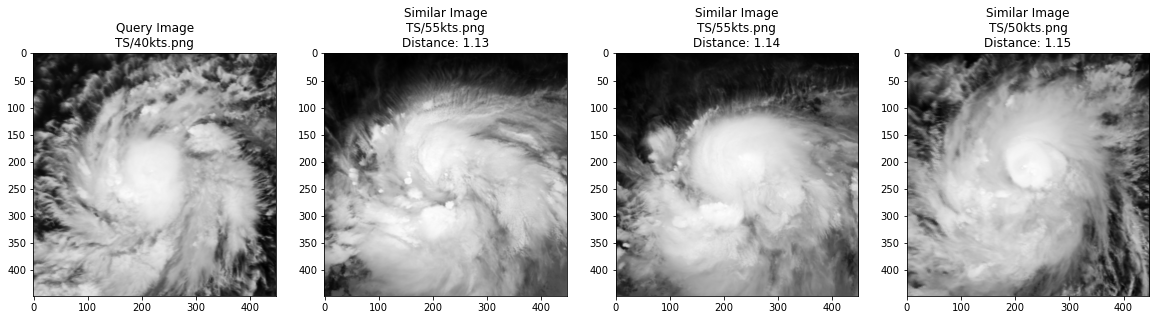

636
[ 636   27 1054  165    0  911  181  578  722  711  531  382  258  362
  368]
[0.0, 0.27, 0.28, 0.3, 0.3, 0.31, 0.33, 0.37, 0.37, 0.38, 0.39, 0.39, 0.39, 0.4, 0.41]
['al042019_advTime_20190821T180000_goesTime_20190821T232507_intensity_35kts.png',
 'al042019_advTime_20190822T000000_goesTime_20190822T022507_intensity_30kts.png',
 'al042019_advTime_20190821T120000_goesTime_20190821T122506_intensity_35kts.png',
 'al042019_advTime_20190821T120000_goesTime_20190821T162506_intensity_35kts.png']


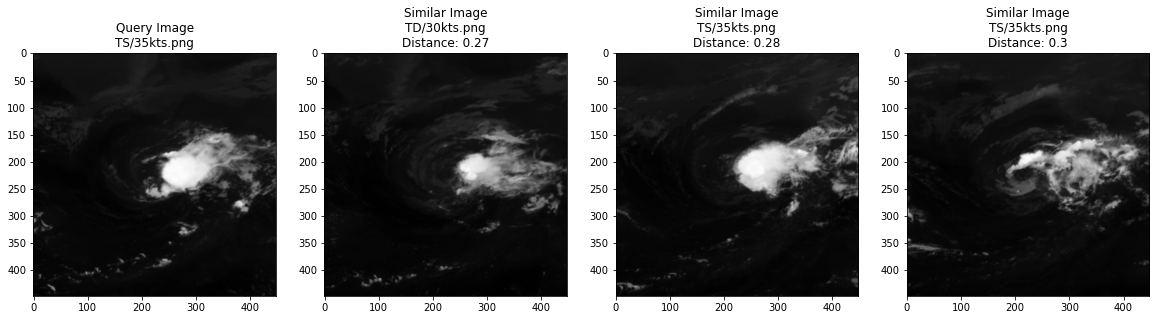

429
[ 429  645  216  851  845  433 1037  284  268  193   92   52  269  620
 1054]
[0.0, 0.4, 0.5, 0.5, 0.51, 0.51, 0.51, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.53, 0.53]
['al142019_advTime_20191013T120000_goesTime_20191013T172516_intensity_40kts.png',
 'al142019_advTime_20191013T180000_goesTime_20191013T222516_intensity_35kts.png',
 'al082019_advTime_20190906T120000_goesTime_20190906T122458_intensity_40kts.png',
 'al082019_advTime_20190906T120000_goesTime_20190906T152458_intensity_40kts.png']


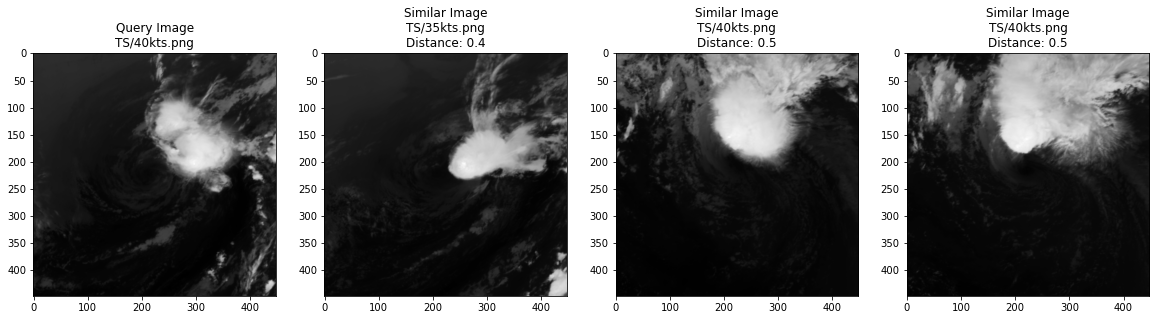

In [36]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
#     random_image_index = 142
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    print(random_image_index)
    print(indices[0][:15])
    print([float("%.2f"%d) for d in distances[0][:15]])
    
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [X_test_paths[random_image_index]] + [X_test_paths[indices[0][i]] for i in range(1, 4)]
    pprint([p.split("/")[-1] for p in similar_image_paths])
    plot_images(similar_image_paths, distances[0], dims=(448, 448, 3))
    plt.show()

In [37]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  1.1328303
Max distance between all photos:  1.823217
Median distance among most similar photos:  0.66288644


In [45]:
selected_features = feature_list[:]
selected_class_ids = [classname(f) for f in X_test_paths[:]]
selected_filenames = X_test_paths[:]

print(len(selected_features))
print(len(selected_class_ids))
print(len(selected_filenames))

# colors = [b,g,r,c,m,y,k,w]
color_class_map = {"TD": 'b', "TS": 'g', "C1": 'r', "C2": 'c', "C3": 'm', "C4": 'y', "C5": 'k'}
selected_class_ids = [color_class_map[cid] for cid in selected_class_ids]

# print(selected_class_ids)

1069
1069
1069


In [52]:
import time
from sklearn.manifold import TSNE

# You can play with these values and see how the results change
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(selected_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1069 samples in 0.259s...
[t-SNE] Computed neighbors for 1069 samples in 8.811s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1069
[t-SNE] Computed conditional probabilities for sample 1069 / 1069
[t-SNE] Mean sigma: 0.257906
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.773026
[t-SNE] KL divergence after 1000 iterations: 0.878452
t-SNE done! Time elapsed: 11.578590393066406 seconds


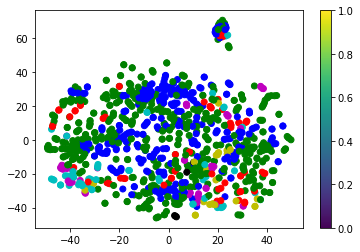

In [53]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.savefig(FEATURES_PARENT_DIR + "/tSNE_scatter.png")
plt.show()
# To save the plot in a high definition format i.e. PDF, uncomment the following line:


In [60]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

dims=(448, 448, 3)
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.fromarray(np.uint8(resize(plt.imread((image_path))[:,:,:3], dims)*255))
#         image = Image.fromarray(np.uint8(np.load(image_path)*255))
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [61]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_scatter.png")
    plt.show()

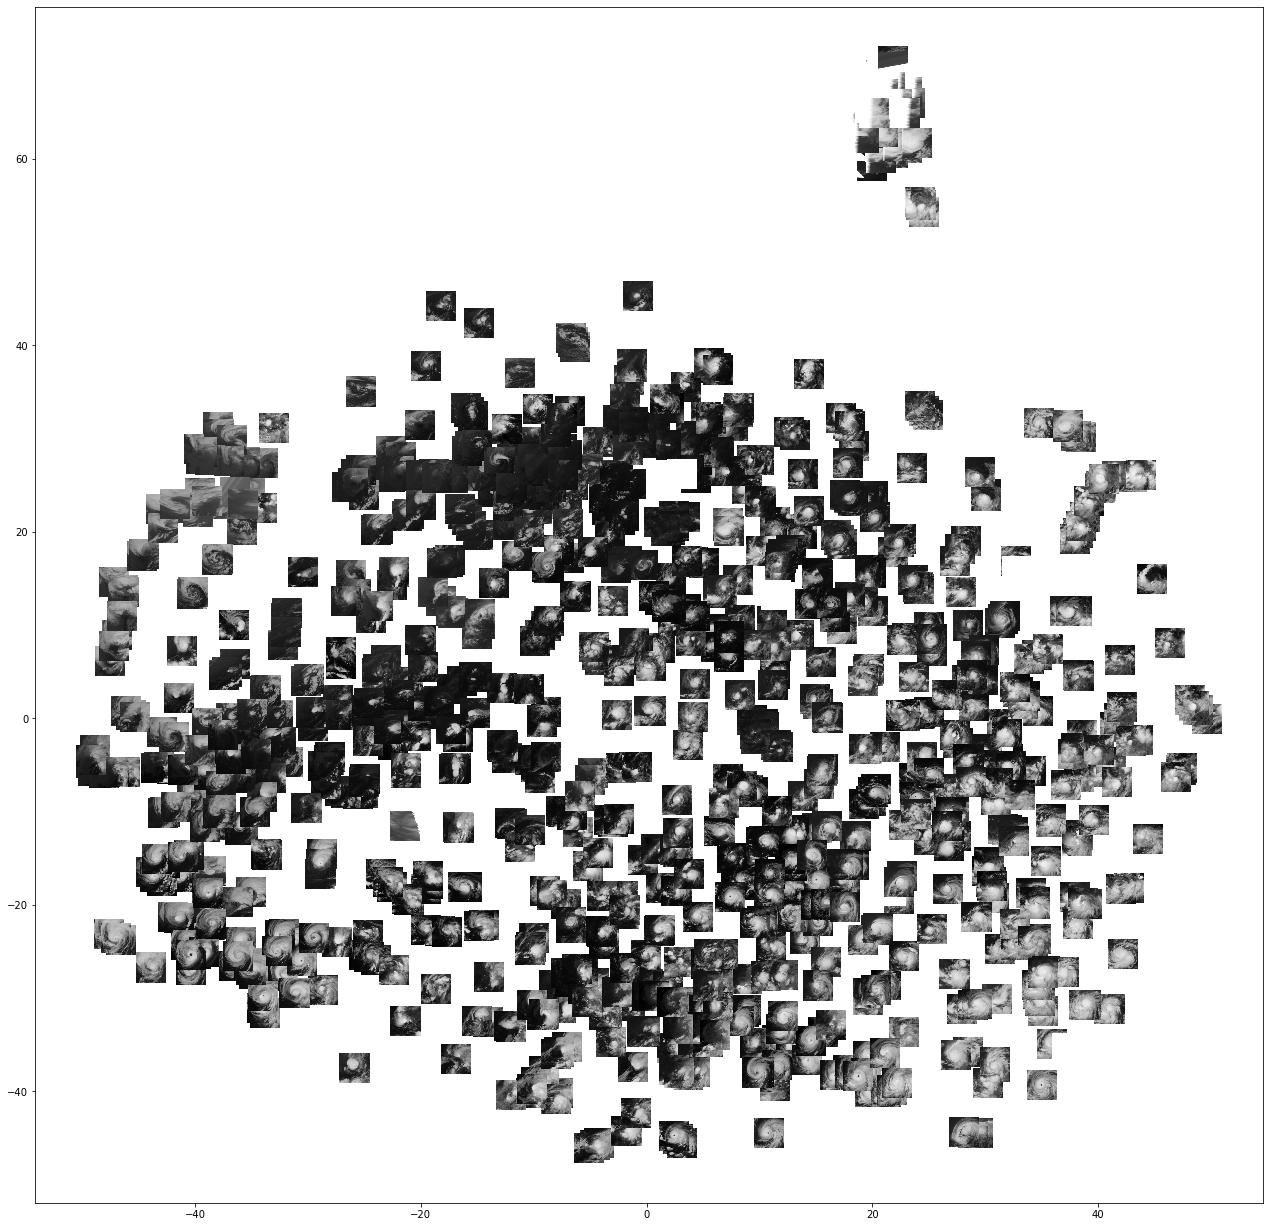

In [62]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [63]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_grid.png")
    plt.show()

In [64]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)